# POS Tagging - Lexicon and Rule Based Taggers

Let's look at the two most basic tagging techniques - lexicon based (or unigram) and rule-based.

In this guided exercise, you will explore the WSJ (wall street journal) POS-tagged corpus that comes with NLTK and build a lexicon and rule-based tagger using this corpus as the tarining data.

This exercise is divided into the following sections:

    Reading and understanding the tagged dataset
    Exploratory analysis
    Lexicon and rule-based models:
        Creating and evaluating a lexicon POS tagger
        Creating and evaluating a rule-based POS tagger



In [15]:
# Importing libraries
import nltk
import numpy as np
import pandas as pd
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import math

nltk.download('treebank')
nltk.download('tagsets')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\BhagavanReddy\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\BhagavanReddy\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping help\tagsets.zip.


True

In [4]:
wsj = list(nltk.corpus.treebank.tagged_sents())

In [5]:
wsj[:2]

[[('Pierre', 'NNP'),
  ('Vinken', 'NNP'),
  (',', ','),
  ('61', 'CD'),
  ('years', 'NNS'),
  ('old', 'JJ'),
  (',', ','),
  ('will', 'MD'),
  ('join', 'VB'),
  ('the', 'DT'),
  ('board', 'NN'),
  ('as', 'IN'),
  ('a', 'DT'),
  ('nonexecutive', 'JJ'),
  ('director', 'NN'),
  ('Nov.', 'NNP'),
  ('29', 'CD'),
  ('.', '.')],
 [('Mr.', 'NNP'),
  ('Vinken', 'NNP'),
  ('is', 'VBZ'),
  ('chairman', 'NN'),
  ('of', 'IN'),
  ('Elsevier', 'NNP'),
  ('N.V.', 'NNP'),
  (',', ','),
  ('the', 'DT'),
  ('Dutch', 'NNP'),
  ('publishing', 'VBG'),
  ('group', 'NN'),
  ('.', '.')]]

In [7]:
#In the list mentioned above, each element of the list is a sentence. Also, note that each sentence ends with a full stop '.' whose POS tag is also a '.'. Thus, the POS tag '.' demarcates the end of a sentence.

#Also, we do not need the corpus to be segmented into sentences, but can rather use a list of (word, tag) tuples. Let's convert the list into a (word, tag) tuple

In [9]:
# converting the list of sents to a list of (word, pos tag) tuples
tagged_words = [tup for sent in wsj for tup in sent]
print(len(tagged_words))
tagged_words[:4]

100676


[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD')]

# 2. Exploratory Analysis

Let's now conduct some basic exploratory analysis to understand the tagged corpus. To start with, let's ask some simple questions:

    How many unique tags are there in the corpus?
    Which is the most frequent tag in the corpus?
    Which tag is most commonly assigned to the following words:
        "bank"
        "executive"



In [10]:
# question 1: Find the number of unique POS tags in the corpus
# you can use the set() function on the list of tags to get a unique set of tags, 
# and compute its length
tags = [pair[1] for pair in tagged_words]
unique_tags = set(tags)
len(unique_tags)

46

In [11]:
# question 2: Which is the most frequent tag in the corpus
# to count the frequency of elements in a list, the Counter() class from collections
# module is very useful, as shown below

from collections import Counter
tag_counts = Counter(tags)
tag_counts

Counter({'NNP': 9410,
         ',': 4886,
         'CD': 3546,
         'NNS': 6047,
         'JJ': 5834,
         'MD': 927,
         'VB': 2554,
         'DT': 8165,
         'NN': 13166,
         'IN': 9857,
         '.': 3874,
         'VBZ': 2125,
         'VBG': 1460,
         'CC': 2265,
         'VBD': 3043,
         'VBN': 2134,
         '-NONE-': 6592,
         'RB': 2822,
         'TO': 2179,
         'PRP': 1716,
         'RBR': 136,
         'WDT': 445,
         'VBP': 1321,
         'RP': 216,
         'PRP$': 766,
         'JJS': 182,
         'POS': 824,
         '``': 712,
         'EX': 88,
         "''": 694,
         'WP': 241,
         ':': 563,
         'JJR': 381,
         'WRB': 178,
         '$': 724,
         'NNPS': 244,
         'WP$': 14,
         '-LRB-': 120,
         '-RRB-': 126,
         'PDT': 27,
         'RBS': 35,
         'FW': 4,
         'UH': 3,
         'SYM': 1,
         'LS': 13,
         '#': 16})

In [13]:
tag_counts.most_common(4)

[('NN', 13166), ('IN', 9857), ('NNP', 9410), ('DT', 8165)]

In [16]:
# list of POS tags in NLTK
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [17]:
# question 3: Which tag is most commonly assigned to the word w.
bank = [pair for pair in tagged_words if pair[0].lower() == 'bank']
bank

[('bank', 'NN'),
 ('Bank', 'NNP'),
 ('bank', 'NN'),
 ('Bank', 'NNP'),
 ('bank', 'NN'),
 ('Bank', 'NNP'),
 ('bank', 'NN'),
 ('Bank', 'NNP'),
 ('bank', 'NN'),
 ('bank', 'NN'),
 ('bank', 'NN'),
 ('Bank', 'NNP'),
 ('Bank', 'NNP'),
 ('Bank', 'NNP'),
 ('Bank', 'NNP'),
 ('bank', 'NN'),
 ('bank', 'NN'),
 ('bank', 'NN'),
 ('bank', 'NN'),
 ('bank', 'NN'),
 ('Bank', 'NNP'),
 ('Bank', 'NNP'),
 ('Bank', 'NNP'),
 ('bank', 'NN'),
 ('Bank', 'NNP'),
 ('Bank', 'NNP'),
 ('bank', 'NN'),
 ('Bank', 'NNP'),
 ('Bank', 'NNP'),
 ('bank', 'NN'),
 ('bank', 'NN'),
 ('Bank', 'NNP'),
 ('bank', 'NN'),
 ('bank', 'NN'),
 ('bank', 'NN'),
 ('Bank', 'NNP'),
 ('bank', 'NN'),
 ('bank', 'NN'),
 ('bank', 'NN'),
 ('bank', 'NN'),
 ('bank', 'NN'),
 ('Bank', 'NNP'),
 ('Bank', 'NNP'),
 ('Bank', 'NNP'),
 ('bank', 'NN'),
 ('Bank', 'NNP'),
 ('Bank', 'NNP'),
 ('Bank', 'NNP'),
 ('Bank', 'NNP'),
 ('Bank', 'NNP'),
 ('Bank', 'NNP'),
 ('Bank', 'NNP'),
 ('Bank', 'NNP'),
 ('Bank', 'NNP'),
 ('bank', 'NN'),
 ('bank', 'NN'),
 ('Bank', 'NNP'),
 

# 2. Exploratory Analysis Contd.

Until now, we were looking at the frequency of tags assigned to particular words, which is the basic idea used by lexicon or unigram taggers. Let's now try observing some rules which can potentially be used for POS tagging.

To start with, let's see if the following questions reveal something useful:

    What fraction of words with the tag 'VBD' (verb, past tense) end with the letters 'ed'
    What fraction of words with the tag 'VBG' (verb, present participle/gerund) end with the letters 'ing'



In [20]:
# 4. how many words with the tag 'VBD' (verb, past tense) end with 'ed'
past_tense = [pair for pair in tagged_words if pair[1]=='VBD']
ed_verbs = [pair for pair in past_tense if pair[0].endswith('ed')]
print(len(ed_verbs))
print(len(ed_verbs)/len(past_tense))
ed_verbs[:5]

1181
0.3881038448899113


[('reported', 'VBD'),
 ('stopped', 'VBD'),
 ('studied', 'VBD'),
 ('led', 'VBD'),
 ('worked', 'VBD')]

In [22]:
# question: what fraction of adjectives JJ are followed by a noun NN
tags = [pair[1] for pair in tagged_words]
jj_tags = [t for t in tags if t == 'JJ']
# create a list of (JJ, NN) tags
jj_nn_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='JJ' and tags[index+1]=='NN']

print(len(jj_tags))
print(len(jj_nn_tags))
print(len(jj_nn_tags) / len(jj_tags))

5834
2611
0.4475488515598217


In [24]:
# question: what fraction of modals MD are followed by a verb VB?
md_tags = [t for t in tags if t == 'MD']
md_vb_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='MD' and tags[index+1]=='VB']

print(len(md_tags))
print(len(md_vb_tags))
print(len(md_vb_tags) / len(md_tags))

927
756
0.8155339805825242


# 3. Lexicon and Rule-Based Models for POS Tagging

Let's now see lexicon and rule-based models for POS tagging. We'll first split the corpus into training and test sets and then use built-in NLTK taggers.
3.1 Splitting into Train and Test Sets

In [32]:
# splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(wsj, test_size=0.3)

print(len(train_set))
print(len(test_set))
print(train_set[:2])

2739
1175
[[('The', 'DT'), ('index', 'NN'), ('of', 'IN'), ('the', 'DT'), ('100', 'CD'), ('largest', 'JJS'), ('Nasdaq', 'NNP'), ('financial', 'JJ'), ('stocks', 'NNS'), ('rose', 'VBD'), ('modestly', 'RB'), ('as', 'IN'), ('well', 'RB'), (',', ','), ('*-1', '-NONE-'), ('gaining', 'VBG'), ('1.28', 'CD'), ('to', 'TO'), ('449.04', 'CD'), ('.', '.')], [('Last', 'JJ'), ('year', 'NN'), (',', ','), ('it', 'PRP'), ('had', 'VBD'), ('*-1', '-NONE-'), ('to', 'TO'), ('buy', 'VB'), ('sugar', 'NN'), ('on', 'IN'), ('the', 'DT'), ('world', 'NN'), ('market', 'NN'), ('*-2', '-NONE-'), ('to', 'TO'), ('meet', 'VB'), ('export', 'NN'), ('commitments', 'NNS'), (',', ','), ('they', 'PRP'), ('noted', 'VBD'), ('0', '-NONE-'), ('*T*-3', '-NONE-'), ('.', '.')]]


# 3.2 Lexicon (Unigram) Tagger

Let's now try training a lexicon (or a unigram) tagger which assigns the most commonly assigned tag to a word.

In NLTK, the UnigramTagger() can be used to train such a model.


In [25]:
unigram = nltk.UnigramTagger(train_set)
unigram.evaluate(test_set)

0.8718433931484503

### 3.3. Rule-Based (Regular Expression) Tagger

Now let's build a rule-based, or regular expression based tagger. In NLTK, the RegexpTagger() can be provided with handwritten regular expression patterns, as shown below.

In the example below, we specify regexes for gerunds and past tense verbs (as seen above), 3rd singular present verb (creates, moves, makes etc.), modal verbs MD (should, would, could), possesive nouns (partner's, bank's etc.), plural nouns (banks, institutions), cardinal numbers CD and finally, if none of the above rules are applicable to a word, we tag the most frequent tag NN.


In [26]:
# specify patterns for tagging
# example from the NLTK book
patterns = [
    (r'.*ing$', 'VBG'),              # gerund
    (r'.*ed$', 'VBD'),               # past tense
    (r'.*es$', 'VBZ'),               # 3rd singular present
    (r'.*ould$', 'MD'),              # modals
    (r'.*\'s$', 'NN$'),              # possessive nouns
    (r'.*s$', 'NNS'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), # cardinal numbers
    (r'.*', 'NN')                    # nouns
]

In [28]:
regexp_tagger = nltk.RegexpTagger(patterns)
# help(regexp_tagger)
regexp_tagger.evaluate(test_set)

0.22205546492659053

### 3.4 Combining Taggers

Let's now try combining the taggers created above. We saw that the rule-based tagger by itself is quite ineffective since we've only written a handful of rules. However, if we could combine the lexicon and the rule-based tagger, we can potentially create a tagger much better than any of the individual ones.

NLTK provides a convenient way to combine taggers using the 'backup' argument. In the following code, we create a regex tagger which is used as a backup tagger to the lexicon tagger, i.e. when the tagger is not able to tag using the lexicon (in case of a new word not in the vocabulary), it uses the rule-based tagger.

Also, note that the rule-based tagger itself is backed up by the tag 'NN'.


In [29]:
rule_based = nltk.RegexpTagger(patterns)
lexicon = nltk.UnigramTagger(train_set, backoff = rule_based)
lexicon.evaluate(test_set)

0.9043066884176183

# POS Tagging, HMMs, Viterbi

Let's learn how to do POS tagging by Viterbi Heuristic using tagged Treebank corpus. Before going through the code, let's first understand the pseudo-code for the same.

    Tagged Treebank corpus is available (Sample data to training and test data set)
        Basic text and structure exploration
    Creating HMM model on the tagged data set.
        Calculating Emission Probabaility: P(observation|state)
        Calculating Transition Probability: P(state2|state1)
    Developing algorithm for Viterbi Heuristic
    Checking accuracy on the test data set


In [30]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [33]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

70565

In [36]:
tokens = [pair[0] for pair in train_tagged_words]
tokens[:5]

['The', 'index', 'of', 'the', '100']

In [41]:
V = set(tokens)
print(len(V))

10245


In [40]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
print(T)

46
{'-LRB-', 'NNS', 'VBD', ':', 'JJS', 'RB', '.', 'NNPS', 'DT', 'JJR', 'RBS', "''", '-NONE-', '$', '#', 'NN', 'PDT', 'PRP', 'POS', 'WP', 'NNP', 'MD', 'VBN', 'WDT', 'CC', 'RP', 'VBZ', '-RRB-', 'UH', 'VBP', 'JJ', 'WP$', ',', 'EX', 'SYM', 'PRP$', 'VB', '``', 'RBR', 'WRB', 'LS', 'IN', 'FW', 'VBG', 'CD', 'TO'}


## 2. POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word.

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).

P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e.

P(w/t) = count(w, t) / count(t).

The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).

Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero.


In [42]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [43]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_tagged_words if pair[1]==tag]
    count_tags = len(tag_list)
    word_with_tags = [pair for pair in tag_list if pair[0]==word]
    count_word_with_tags = len(word_with_tags)
    
    return(count_word_with_tags, count_tags)

In [46]:
# examples
print("word = large")
print(word_given_tag('large', 'JJ'),word_given_tag('large', 'VB'), word_given_tag('large', 'NN'))
print("\n", "word = will")
print(word_given_tag('will', 'MD'), word_given_tag('will', 'NN'), word_given_tag('will', 'VB'))

word = large
(20, 4104) (0, 1793) (0, 9180)

 word = will
(194, 637) (1, 9180) (0, 1793)


# Transition Probability

In [47]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [48]:
# examples
print(t2_given_t1(t2='NNP', t1='JJ'))
print(t2_given_t1('NN', 'JJ'), t2_given_t1('NN', 'DT'), t2_given_t1(',', 'NNP'), t2_given_t1('PRP', 'PRP'))
print(t2_given_t1('VBG', 'NNP'))

(137, 4104)
(1830, 4104) (2681, 5707) (994, 6590) (3, 1218)
(5, 6590)


In [49]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DT', '.'), t2_given_t1('VBG', '.'), t2_given_t1('NN', '.'), t2_given_t1('NNP', '.'))

(582, 2710) (8, 2710) (116, 2710) (487, 2710)


In [50]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]
        
tags_matrix

array([[0.        , 0.02061856, 0.        , ..., 0.01030928, 0.08247422,
        0.        ],
       [0.00355282, 0.01279015, 0.07792515, ..., 0.01231644, 0.00189484,
        0.01942207],
       [0.00046598, 0.02003728, 0.        , ..., 0.02050326, 0.04892824,
        0.02516309],
       ...,
       [0.        , 0.10068426, 0.00097752, ..., 0.00293255, 0.02248289,
        0.04398827],
       [0.00158919, 0.1458085 , 0.00556218, ..., 0.0011919 , 0.18712753,
        0.02701629],
       [0.        , 0.0282523 , 0.        , ..., 0.00131406, 0.07621551,
        0.        ]], dtype=float32)

In [51]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df.head()

,-LRB-,NNS,VBD,:,JJS,RB,.,NNPS,DT,JJR,...,VB,``,RBR,WRB,LS,IN,FW,VBG,CD,TO
-LRB-,0.000000,0.020619,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.082474,0.020619,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.082474,0.0,0.010309,0.082474,0.000000
NNS,0.003553,0.012790,0.077925,0.018238,0.0,0.025817,0.119375,0.0,0.014211,0.002605,...,0.004737,0.001421,0.001658,0.002605,0.000000,0.240407,0.0,0.012316,0.001895,0.019422
VBD,0.000466,0.020037,0.000000,0.001864,0.0,0.079683,0.004660,0.0,0.123952,0.006990,...,0.002330,0.003728,0.002330,0.001398,0.000000,0.107176,0.0,0.020503,0.048928,0.025163
:,0.000000,0.038660,0.025773,0.000000,0.0,0.033505,0.010309,0.0,0.113402,0.005155,...,0.007732,0.054124,0.000000,0.007732,0.007732,0.100515,0.0,0.012887,0.090206,0.002577
JJS,0.000000,0.141732,0.007874,0.000000,0.0,0.039370,0.015748,0.0,0.007874,0.000000,...,0.015748,0.000000,0.000000,0.000000,0.000000,0.196850,0.0,0.023622,0.055118,0.000000


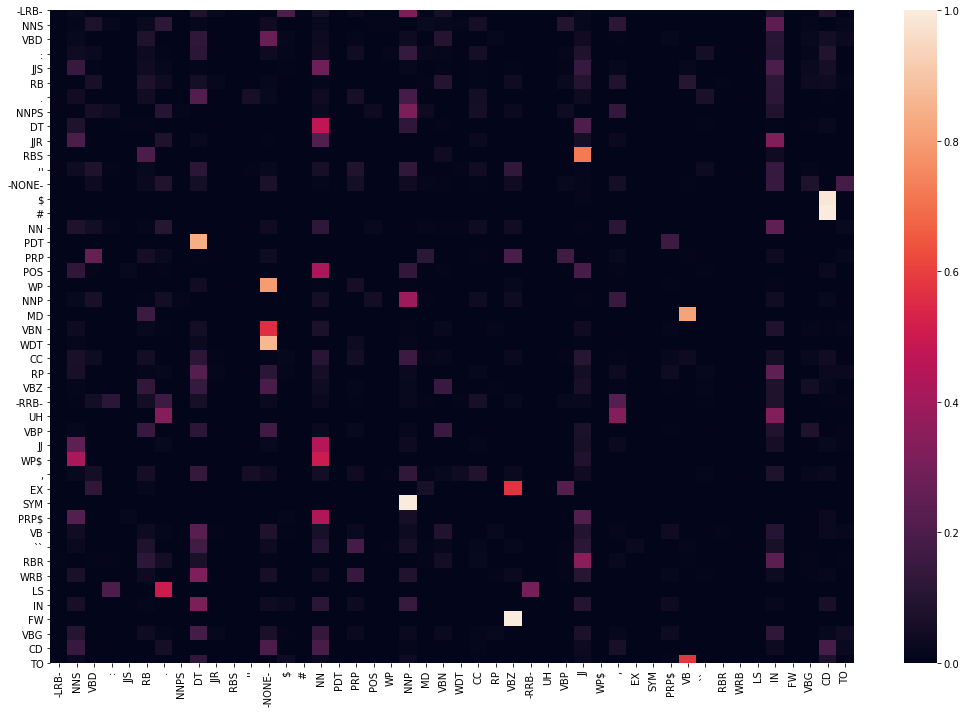

In [52]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

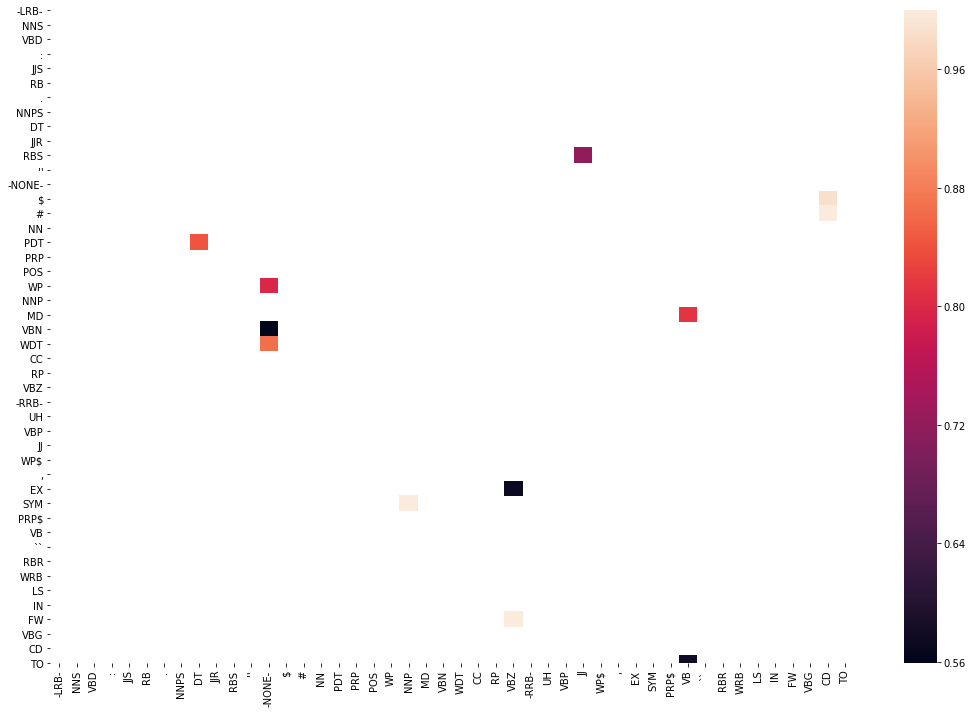

In [53]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### 3. Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.')


In [55]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [56]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Argentine', 'JJ'),
  ('negotiator', 'NN'),
  ('Carlos', 'NNP'),
  ('Carballo', 'NNP'),
  ('was', 'VBD'),
  ('in', 'IN'),
  ('Washington', 'NNP'),
  ('and', 'CC'),
  ('New', 'NNP'),
  ('York', 'NNP'),
  ('this', 'DT'),
  ('week', 'NN'),
  ('*-1', '-NONE-'),
  ('to', 'TO'),
  ('meet', 'VB'),
  ('with', 'IN'),
  ('banks', 'NNS'),
  ('.', '.')],
 [('The', 'DT'),
  ('roofs', 'NNS'),
  ('would', 'MD'),
  ('be', 'VB'),
  ('required', 'VBN'),
  ('*-1', '-NONE-'),
  ('to', 'TO'),
  ('withstand', 'VB'),
  ('a', 'DT'),
  ('force', 'NN'),
  ('of', 'IN'),
  ('1.5', 'CD'),
  ('times', 'NNS'),
  ('the', 'DT'),
  ('unloaded', 'JJ'),
  ('weight', 'NN'),
  ('of', 'IN'),
  ('the', 'DT'),
  ('vehicle', 'NN'),
  ('.', '.')],
 [('California', 'NNP'),
  ("'s", 'POS'),
  ('education', 'NN'),
  ('department', 'NN'),
  ('suspects', 'VBZ'),
  ('adult', 'NN'),
  ('responsibility', 'NN'),
  ('for', 'IN'),
  ('erasures', 'NNS'),
  ('at', 'IN'),
  ('40', 'CD'),
  ('schools', 'NNS'),
  ('that', 'WDT'),
  ('*T*-85

In [57]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [58]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  85.6999921798706
[('Argentine', '-LRB-'), ('negotiator', '-LRB-'), ('Carlos', 'NNP'), ('Carballo', '-LRB-'), ('was', '-LRB-'), ('in', 'IN'), ('Washington', 'NNP'), ('and', 'CC'), ('New', 'NNP'), ('York', 'NNP'), ('this', 'DT'), ('week', 'NN'), ('*-1', '-NONE-'), ('to', 'TO'), ('meet', 'VB'), ('with', 'IN'), ('banks', 'NNS'), ('.', '.'), ('The', 'DT'), ('roofs', 'NNS'), ('would', 'MD'), ('be', 'VB'), ('required', 'VBN'), ('*-1', '-NONE-'), ('to', 'TO'), ('withstand', 'VB'), ('a', 'DT'), ('force', 'NN'), ('of', 'IN'), ('1.5', 'CD'), ('times', 'NNS'), ('the', 'DT'), ('unloaded', '-LRB-'), ('weight', '-LRB-'), ('of', 'IN'), ('the', 'DT'), ('vehicle', 'NN'), ('.', '.'), ('California', 'NNP'), ("'s", 'POS'), ('education', 'NN'), ('department', 'NN'), ('suspects', 'NNS'), ('adult', 'NN'), ('responsibility', 'NN'), ('for', 'IN'), ('erasures', '-LRB-'), ('at', 'IN'), ('40', 'CD'), ('schools', 'NNS'), ('that', 'IN'), ('*T*-85', '-LRB-'), ('changed', 'VBN'), ('wrong', 'JJ'

In [60]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
print("accuracy = ", len(check)/len(tagged_seq))

accuracy =  0.8487394957983193


In [61]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('.', '.'), (('Argentine', '-LRB-'), ('Argentine', 'JJ'))],
 [('Argentine', 'JJ'), (('negotiator', '-LRB-'), ('negotiator', 'NN'))],
 [('Carlos', 'NNP'), (('Carballo', '-LRB-'), ('Carballo', 'NNP'))],
 [('Carballo', 'NNP'), (('was', '-LRB-'), ('was', 'VBD'))],
 [('the', 'DT'), (('unloaded', '-LRB-'), ('unloaded', 'JJ'))],
 [('unloaded', 'JJ'), (('weight', '-LRB-'), ('weight', 'NN'))],
 [('department', 'NN'), (('suspects', 'NNS'), ('suspects', 'VBZ'))],
 [('for', 'IN'), (('erasures', '-LRB-'), ('erasures', 'NNS'))],
 [('schools', 'NNS'), (('that', 'IN'), ('that', 'WDT'))],
 [('that', 'WDT'), (('*T*-85', '-LRB-'), ('*T*-85', '-NONE-'))],
 [('*T*-85', '-NONE-'), (('changed', 'VBN'), ('changed', 'VBD'))],
 [('to', 'TO'), (('right', 'NN'), ('right', 'JJ'))],
 [('are', 'VBP'), (('worth', 'JJ'), ('worth', 'IN'))],
 [('*', '-NONE-'), (('preserving', '-LRB-'), ('preserving', 'VBG'))],
 [('for', 'IN'), (('aesthetic', '-LRB-'), ('aesthetic', 'JJ'))],
 [('one', 'CD'), (('famed', '-LRB-'), ('fame

In [62]:
## Testing
sentence_test = 'Twitter is the best networking social site. Man is a social animal. Data science is an emerging field. Data science jobs are high in demand.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [63]:
print(tagged_seq)
print(difference)

[('Twitter', '-LRB-'), ('is', '-LRB-'), ('the', 'DT'), ('best', 'JJS'), ('networking', '-LRB-'), ('social', 'JJ'), ('site', '-LRB-'), ('.', '-LRB-'), ('Man', 'NNP'), ('is', 'VBZ'), ('a', 'DT'), ('social', 'JJ'), ('animal', '-LRB-'), ('.', '-LRB-'), ('Data', '-LRB-'), ('science', 'NN'), ('is', 'VBZ'), ('an', 'DT'), ('emerging', 'VBG'), ('field', 'NN'), ('.', '.'), ('Data', '-LRB-'), ('science', 'NN'), ('jobs', 'NNS'), ('are', 'VBP'), ('high', 'JJ'), ('in', 'IN'), ('demand', 'NN'), ('.', '.')]
18.772403478622437
